# Programming Assignment 3 - Logistic regression without libraries

CAP 5625 Computational Foundations of AI - Fall 2021 - Dr. DeGiorgio
<br>Christian Garbin

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [1]:
import copy
from typing import Tuple
import numpy as np
import pandas as pd

# Import and set up the graphing environment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots legible and focus on trends (not specific values)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2})
sns.despine();

<Figure size 432x288 with 0 Axes>

Import our logistic regression module and the utilities.

In [2]:
import utils
import logistic

# Ancillary code and definitions

Run the automated tests to verify the code works as intended before we start the experiments.

In [3]:
import sys
sys.path.append('./test')
import test_logistic
# Set to true to see each test result
test_logistic.test_all(False, './data')
print('All tests passed')

All tests passed


Constants used in the experiments.

In [4]:
LAMBDAS_TO_TEST = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
NUM_TESTS = len(LAMBDAS_TO_TEST)
LR = 0.00001
NUM_FOLDS = 5

Read the dataset and prepare it by encoding categorical columns, standardizing if asked to do so. Note that there is no caching. For a larger dataset we should probably cache it.

Also set constants that depend on the dataset.

In [8]:
TRAINING_FILE = './data/TrainingData_N183_p10.csv'
TEST_FILE = './data/TestData_N111_p10.csv'
FEATURE_NAMES = []
CLASS_NAMES = []

def read_dataset(file: str, standardize: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    global FEATURE_NAMES, CLASS_NAMES
    
    x, y, y_raw, FEATURE_NAMES, classes = utils.read_dataset(file, hot_encode=True)
    
    # A bit of a hack to store class names only when reading from the training file (the first time)
    if len(CLASS_NAMES) == 0:
        CLASS_NAMES = classes

    if standardize:
        utils.scale(x)
        # Note that y is not centered in this case

    return x, y, y_raw

# Deliverable 1 - effect of lambda on coefficients

> _Illustrate the effect of the tuning parameter on the inferred ridge regression coefficients by generating five plots (one for each of the K = 5 ancestry classes) of 10 lines (one for each of the p = 10 features), with the y-axis as β̂jk, j = 1,2, ... ,10 for the graph of class k, and x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular β̂jk._

Perform logistic regression with the different lambda values (takes several seconds to complete).

In [102]:
betas = []
for lmbda in LAMBDAS_TO_TEST:
    x, y, _ = read_dataset(TRAINING_FILE)
    b = logistic.fit(x, y, lr=LR, lmbda=lmbda, iterations=10_000)
    # Remove beta0, store only the betas for the classes
    betas.append(b[1:, :])

Plot the coefficient for each ethnicity side by side to compare them (Y axis scale is the same for all graphs).

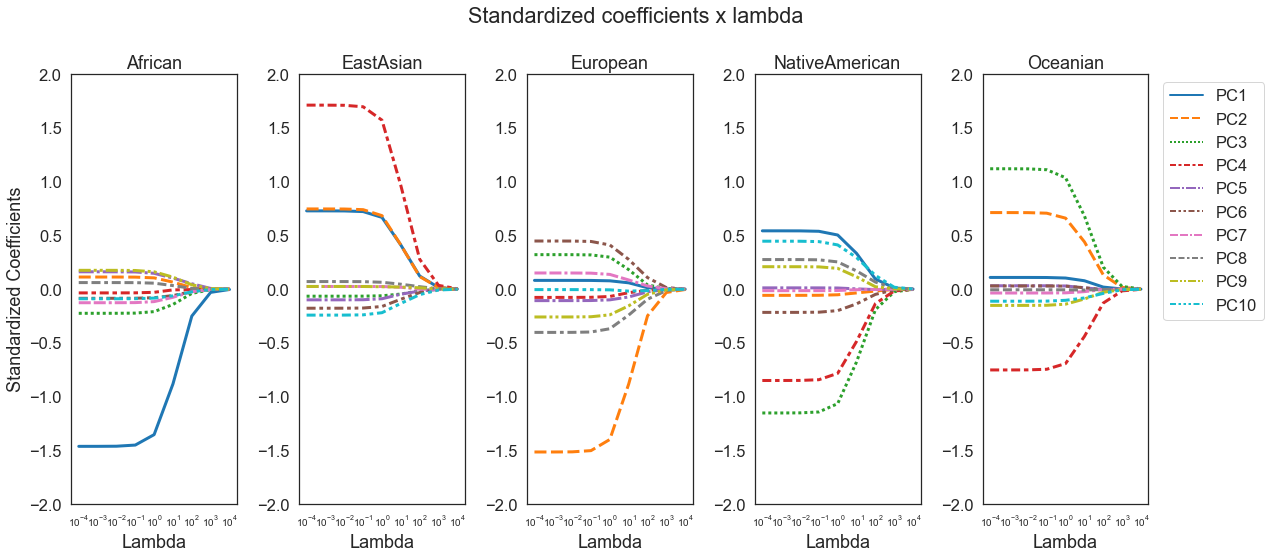

In [153]:
def plot_betas(betas, title, max_y, min_y):
    # Prepare a dataframe in the long format to plot
    df_plot = pd.DataFrame()
    for i, lmbda in enumerate (LAMBDAS_TO_TEST):
        dfx = pd.DataFrame(np.squeeze(betas[i]), columns=CLASS_NAMES, 
                           index=[FEATURE_NAMES, [lmbda]*len(FEATURE_NAMES)])
        df_plot = df_plot.append(dfx)
        dfx_plot = dfx.stack().reset_index()
    df_plot = df_plot.stack().reset_index()
    df_plot.columns = ['Feature', 'Lambda', 'Ethnicity', 'Standardized Coefficients']

    # Plot each class side-by-side, with the same Y axis scale for comparison
    num_classes = len(CLASS_NAMES)
    fig, ax = plt.subplots(1, num_classes, figsize=(18, 8))
    for i, ethnicity in enumerate(CLASS_NAMES):
        sns.lineplot(ax=ax[i], y='Standardized Coefficients', x='Lambda',
                     data=df_plot[df_plot.Ethnicity == ethnicity],
                     hue='Feature', style='Feature', linewidth=3,
                     legend=i == num_classes-1)
        ax[i].set_title(ethnicity)

        # Improve y axis: show only once to save space, use the same scale
        ax[i].axes.set_ylabel('Standardized Coefficients' if i == 0 else '')
        ax[i].set_ylim(min_y, max_y)

        # Improve x axis: log scale, show all tick values (with smaller font)
        ax[i].set_xscale('log')
        ax[i].set_xticks(LAMBDAS_TO_TEST)
        ax[i].tick_params(axis='x', which='major', labelsize=10)
    plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    fig.suptitle(title)
    plt.tight_layout()
    
plot_betas(betas, 'Standardized coefficients x lambda', 2, -2)

# Deliverable 2 - effect of lambda on cross-validation error (categorial cross-entropy)

> _Illustrate the effect of the tuning parameter on the cross validation error by generating a plot with the y-axis as CV(5) error, and the x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular CV(5) error._

Perform logistic regression with the different lambda values and cross validation (takes several seconds to complete).

In [12]:
cce = np.zeros(NUM_TESTS)
for i, lmbda in enumerate(LAMBDAS_TO_TEST):
    x, y, _ = read_dataset(TRAINING_FILE, standardize=False)
    fold_cce = np.zeros(NUM_FOLDS)
    for fold in range(1, NUM_FOLDS+1, 1):
        x_train, x_val, y_train, y_val = utils.split_fold(x, y,
                                                          num_folds=NUM_FOLDS,
                                                          fold=fold)
        utils.scale_val(x_train, x_val)

        model = logistic.fit(x_train, y_train, lr=LR, lmbda=lmbda, iterations=10_000)
        probabilities, _ = logistic.predict(x_val, model)
        fold_cce[fold-1] = logistic.categorical_cross_entropy(y_val, probabilities)
    cce[i] = fold_cce.mean()

Plot the results.

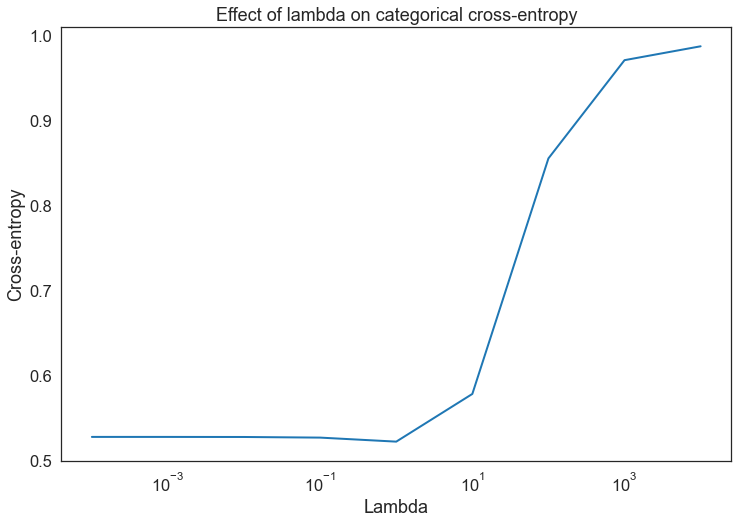

In [13]:
def plot_cce(cce: np.ndarray, title: str):
    # Create a DataFrame in the long format to plot
    df2 = pd.DataFrame([LAMBDAS_TO_TEST, cce]).T
    df2.columns = ['Lambda', 'Cross-entropy']
    
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 8));
    sns.lineplot(ax=ax, y='Cross-entropy', x='Lambda', data=df2)
    ax.set_xscale('log')
    ax.set_title(title)

plot_cce(cce, 'Effect of lambda on categorical cross-entropy')

# Deliverable 3 - the lambda with the smallest cross-validation error

> _Indicate the value of λ value (sic) that generated the smallest CV(5) error._

In [14]:
smallest_cce_index = cce.argmin()
smallest_cce_lambda = LAMBDAS_TO_TEST[smallest_cce_index]
print(f'The lambda with the smallest categorical cross-entropy is {smallest_cce_lambda}')

The lambda with the smallest categorical cross-entropy is 1.0


# Deliverable 4 - model parameters for the lambda with the smallest cross-validation error

> _Given the optimal λ, retrain your model on the entire dataset of N = 183 observations to obtain an estimate of the (p + 1) × K model parameter matrix as B̂ and make predictions of the probability for each of the K = 5 classes for the 111 test individuals located in `TestData_N111_p10.csv`._

Train a model with the lambda that resulted in the smallest categorical cross-entropy.

In [90]:
x, y, y_raw = read_dataset(TRAINING_FILE)
betas4 = logistic.fit(x, y, lr=LR, lmbda=smallest_cce_lambda, iterations=10_000)

#betas4 = logistic.fit(x, y, lr=0.00001, lmbda=0.1, iterations=50_000)

Show the coefficients for this model.

In [91]:
for feature, beta in zip(FEATURE_NAMES, betas4.flatten()):
    print(f'{feature:>4}: {beta:5.2f}')

 PC1: -0.26
 PC2:  0.58
 PC3: -0.02
 PC4: -0.06
 PC5: -0.24
 PC6: -1.35
 PC7:  0.67
 PC8:  0.08
 PC9:  0.50
PC10:  0.10


Predict the values on the test set.

In [92]:
x_test, y_test, y_test_raw = read_dataset(TEST_FILE)
probabilities4, classes4 = logistic.predict(x_test, betas4)

#probabilities4, classes4 = logistic.predict(x_train, betas4)

In [93]:
CLASS_NAMES

['African', 'EastAsian', 'European', 'NativeAmerican', 'Oceanian']

In [94]:
for c, actual in zip(classes4, y_test_raw):
    print(f'{CLASS_NAMES[int(c)]}, {actual}')

Oceanian, ['Unknown']
NativeAmerican, ['Unknown']
European, ['Unknown']
Oceanian, ['Unknown']
EastAsian, ['Unknown']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
European, ['Mexican']
EastAsian, ['Mexican']
European, ['Mexican']
NativeAmerican, ['Mexican']
EastAsian, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexican']
EastAsian, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
European, ['Mexican']
European, ['Mexican']
EastAsian, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
EastAsian, ['Mexican']
NativeAmerican, ['Mexican']
European, ['Mexican']
NativeAmerican, ['Mexican']
NativeAmerican, ['Mexi

# Deliverable 5 - compare with expected real-world results

> How do the class label probabilities differ for the Mexican and African American samples when compared to the class label probabilities for the unknown samples? Are these class probabilities telling us something about recent history? Explain why these class probabilities are reasonable with respect to knowledge of recent history.

# Deliverable 7 - repeat with a machine learning library

> _Implement the assignment using statistical or machine learning libraries in a language of your choice. Compare the results with those obtained above, and provide a discussion as to why you believe your results are different if you found them to be different._

In this section we repeat the experiments above using scikit-learn.

In [97]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics

## Deliverable 7.1 - effect of lambda on coefficients

**NOTE**: we select the `sag` solver in this case to match the algorithm implemented in our code, so the classifiers are comparable. It results in warnings about not being to converge. That's acceptable in this case, because of the large range of lambdas (regularization) we are using in the experiments.

In [161]:
betas_sk = []
for lmbda in LAMBDAS_TO_TEST:
    x, y, y_raw = read_dataset(TRAINING_FILE, standardize=False)
    model_sk = pipeline.make_pipeline(preprocessing.StandardScaler(), 
        linear_model.LogisticRegression(multi_class='multinomial', 
            solver='sag', penalty='l2', C=1/lmbda, random_state=42))
    model_sk.fit(x, y_raw.ravel())
    # scikit returns coefficient in (classes, features)
    # Store its transpose to match our code, so we can plot later
    coef_sk = model_sk.named_steps['logisticregression'].coef_.T
    betas_sk.append(coef_sk)

/Users/cgarbin/fau/regression-no-libraries/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cgarbin/fau/regression-no-libraries/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cgarbin/fau/regression-no-libraries/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/cgarbin/fau/regression-no-libraries/env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Plots the results.

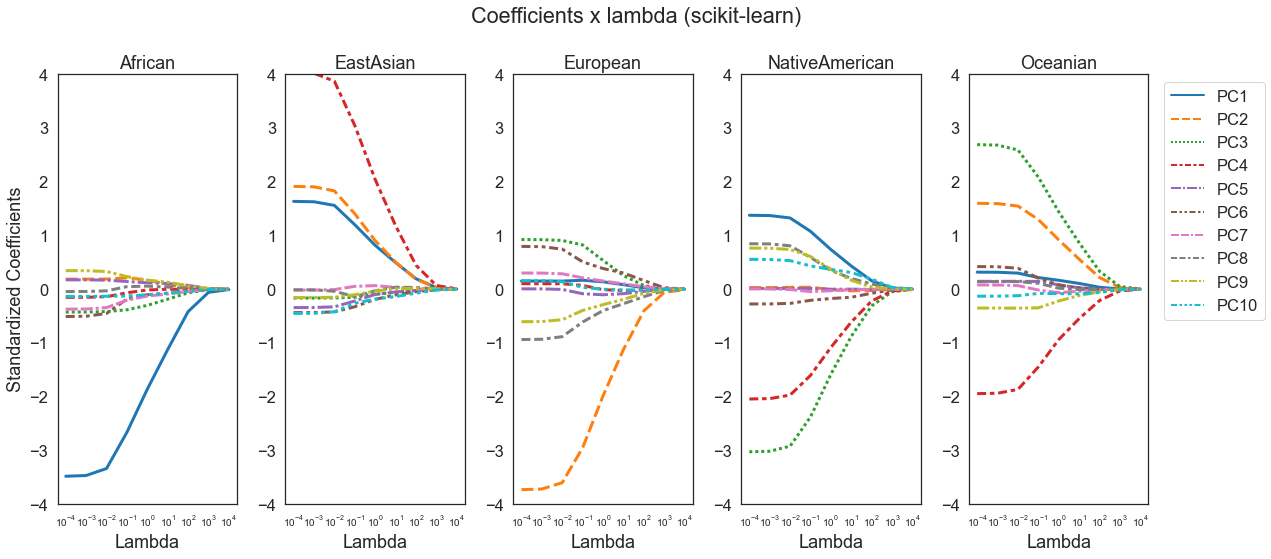

In [163]:
plot_betas(betas_sk, 'Coefficients x lambda (scikit-learn)', 4, -4)

For comparison, the plots below show the coefficient from our code with the same scale as the scikit-learn plot above. We can see that the shape of the curves for each coefficient is about the same. However, the magnitude is twice as large for scikit-learn. We can also see that the L2 regularization of the scikit-learn classifier is more aggressive. It decreases the coefficient values more rapidly than our code.

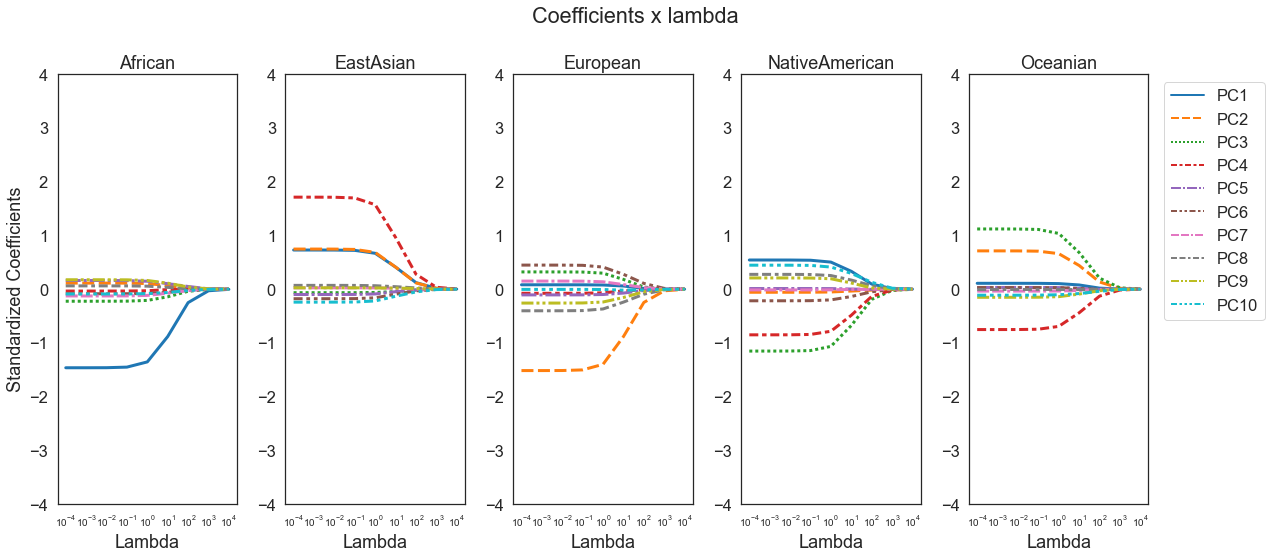

In [164]:
plot_betas(betas, 'Coefficients x lambda', 4, -4)

## Deliverable 7.2 - effect of lambda on cross-validation error (categorial cross-entropy)

Fit one model for each value of lambda. Ask scikit-learn to store the cross-validation results (`store_cv_values`) so we can calculate the mean categorical cross-entropy for each lambda.

In [ ]:
x, y = read_dataset(standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.RidgeCV(alphas=LAMBDAS_TO_TEST,
                           store_cv_values=True))
p.fit(x, y)
model_sk = p.named_steps['ridgecv']

# Mean cross-entropy for each fold
mse_sk = model_sk.cv_values_.mean(axis=0)

Plot the results.

In [ ]:
plot_cce(mse_sk.flatten(), 'Effect of lambda on categorical cross-entropy (scikit-learn)')

## Deliverable 7.3 - the lambda with the smallest cross-validation error

In [ ]:
print(f'The lambda with the smallest categorical cross-entropy is {model_sk.alpha_}')

## Deliverable 7.4 - model parameters for the lambda with the smallest cross-validation error

In [ ]:
x, y = read_dataset(standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.Ridge(alpha=model_sk.alpha_))
p.fit(x, y)
coef_sk = p.named_steps['ridge'].coef_
for feature, beta in zip(FEATURE_NAMES, coef_sk.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

## Deliverable 7.5 - compare with expected real-world results

## Discussion of differences

TODO